<a href="https://colab.research.google.com/github/rafiei91/X-ray_blade_Retina/blob/main/Xray_eager_few_shot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Eager Few Shot Object Detection Colab

Welcome to the Eager Few Shot Object Detection Colab --- in this colab we demonstrate fine tuning of a (TF2 friendly) RetinaNet architecture on very few examples of a novel class after initializing from a pre-trained COCO checkpoint.
Training runs in eager mode.

Estimated time to run through this colab (with GPU): < 5 minutes.

## Imports

In [ ]:
import os
import pathlib

# Clone the tensorflow models repository if it doesn't already exist
if "models" in pathlib.Path.cwd().parts:
  while "models" in pathlib.Path.cwd().parts:
    os.chdir('..')
elif not pathlib.Path('models').exists():
  !git clone --depth 1 https://github.com/tensorflow/models

In [ ]:
# Install the Object Detection API
%%bash
cd models/research/
protoc object_detection/protos/*.proto --python_out=.
cp object_detection/packages/tf2/setup.py .
python -m pip install .

Processing /content/models/research
  Created wheel for object-detection: filename=object_detection-0.1-py3-none-any.whl size=1675218 sha256=9590df6422add780c72e9c295445177819e3c2b3d7f9e5ab952a1e03654d4c65
  Stored in directory: /tmp/pip-ephem-wheel-cache-5d0jwaqc/wheels/fa/a4/d2/e9a5057e414fd46c8e543d2706cd836d64e1fcd9eccceb2329
Successfully built object-detection
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.2.0
    Uninstalling tensorflow-estimator-2.2.0:
      Successfully uninstalled tensorflow-estimator-2.2.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.2.2
    Uninstalling tensorboard-2.2.2:
      Successfully uninstalled tensorboard-2.2.2
  Attempting uninstall: h5py
    Found existing installation: h5py 2.10.0
    Uninstalling h5py-2.10.0:
      Successfully uninstalled h5py-2.10.0
  Attempting uninstall: gast
    Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
   

  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.


In [ ]:
!pip install -U --pre tensorflow=="2.2.0"

  Using cached tensorflow-2.2.0-cp37-cp37m-manylinux2010_x86_64.whl (516.2 MB)
  Using cached h5py-2.10.0-cp37-cp37m-manylinux1_x86_64.whl (2.9 MB)
  Using cached tensorboard-2.2.2-py3-none-any.whl (3.0 MB)
  Using cached tensorflow_estimator-2.2.0-py2.py3-none-any.whl (454 kB)
  Using cached gast-0.3.3-py2.py3-none-any.whl (9.7 kB)
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.6.0
    Uninstalling tensorflow-estimator-2.6.0:
      Successfully uninstalled tensorflow-estimator-2.6.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.7.0
    Uninstalling tensorboard-2.7.0:
      Successfully uninstalled tensorboard-2.7.0
  Attempting uninstall: h5py
    Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0
  Attempting uninstall: gast
    Found existing installation: gast 0.4.0
    Uninstalling gast-0.4.0:
      Successfully uninstalled gast-0.4

In [ ]:
import matplotlib
import matplotlib.pyplot as plt

import os
import random
import io
import imageio
import glob
import scipy.misc
import numpy as np
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont
from IPython.display import display, Javascript
from IPython.display import Image as IPyImage

import tensorflow as tf

from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.utils import colab_utils
from object_detection.builders import model_builder

%matplotlib inline

In [ ]:
!gdown --id 1rVbfYAnsmuNrOerLvk1oB8QhdPIp61Pd

Downloading...
From: https://drive.google.com/uc?id=1rVbfYAnsmuNrOerLvk1oB8QhdPIp61Pd
To: /content/detected.rar
100% 11.2M/11.2M [00:00<00:00, 30.7MB/s]


In [ ]:
!unrar x "/content/detected.rar" -d '.models/research/object_detection/test_images/blade/train/'


UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal


Extracting from /content/detected.rar


Would you like to replace the existing file .models/research/object_detection/test_images/blade/train/detected/BBs.txt
  8764 bytes, modified on 2021-10-14 11:49
with a new one
  8764 bytes, modified on 2021-10-14 11:49

[Y]es, [N]o, [A]ll, n[E]ver, [R]ename, [Q]uit A

Extracting  .models/research/object_detection/test_images/blade/train/detected/BBs.txt       0%  OK 
Extracting  .models/research/object_detection/test_images/blade/train/detected/V0001.jpg       9%  OK 
Extracting  .models/research/object_detection/test_images/blade/train/detected/V0002.jpg      18%  OK 
Extracting  .models/research/object_detection/test_images/blade/train/detected/V0003.jpg      19%  OK 
Extracting  .models/research/object_detection/test_images/blade/train/detected/V0004.jpg      20%  OK 
Extracting  .models/research/object_detection/test_images/blade

In [ ]:
#pip install googledrivedownloader

In [ ]:
#https://drive.google.com/drive/folders/1B-XVUyQqdKkK08gZt0djA9kr7RP71eaq?usp=sharing

In [ ]:
#from google_drive_downloader import GoogleDriveDownloader as gdd

#gdd.download_file_from_google_drive(file_id='1B-XVUyQqdKkK08gZt0djA9kr7RP71eaq',
 #                                   dest_path='.models/research/object_detection/test_images/blade/train/')

In [ ]:
#from google.colab import drive
#drive.mount('/content/gdrive')

#!cp '/content/gdrive/My Drive/detected' detected

In [ ]:
#!cp https://drive.google.com/drive/folders/1B-XVUyQqdKkK08gZt0djA9kr7RP71eaq?usp=sharing detected

In [ ]:
#import json

#data = {"web": {"client_id": "987881522452-6q5n1e8ahd01el12t5kiiqcvuhl69flt.apps.googleusercontent.com", "project_id": "certain-beach-329411", "auth_uri": "https://accounts.google.com/o/oauth2/auth", "token_uri": "https://oauth2.googleapis.com/token", "auth_provider_x509_cert_url": "https://www.googleapis.com/oauth2/v1/certs", "client_secret": "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", "redirect_uris": ["http://localhost:8080/"], "javascript_origins": ["http://localhost:8080"]}}

#jsonString = json.dumps(data)
#jsonFile = open("client_secrets.json", "w")
#jsonFile.write(jsonString)
#jsonFile.close()

In [ ]:
#!pip install pydrive

#from pydrive.auth import GoogleAuth
#from pydrive.drive import GoogleDrive

#gauth = GoogleAuth()
#gauth.LocalWebserverAuth()




# Utilities

In [ ]:
def load_image_into_numpy_array(path):
  """Load an image from file into a numpy array.

  Puts image into numpy array to feed into tensorflow graph.
  Note that by convention we put it into a numpy array with shape
  (height, width, channels), where channels=3 for RGB.

  Args:
    path: a file path.

  Returns:
    uint8 numpy array with shape (img_height, img_width, 3)
  """
  img_data = tf.io.gfile.GFile(path, 'rb').read()
  image = Image.open(BytesIO(img_data))
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

def plot_detections(image_np,
                    boxes,
                    classes,
                    scores,
                    category_index,
                    figsize=(12, 16),
                    image_name=None):
  """Wrapper function to visualize detections.

  Args:
    image_np: uint8 numpy array with shape (img_height, img_width, 3)
    boxes: a numpy array of shape [N, 4]
    classes: a numpy array of shape [N]. Note that class indices are 1-based,
      and match the keys in the label map.
    scores: a numpy array of shape [N] or None.  If scores=None, then
      this function assumes that the boxes to be plotted are groundtruth
      boxes and plot all boxes as black with no classes or scores.
    category_index: a dict containing category dictionaries (each holding
      category index `id` and category name `name`) keyed by category indices.
    figsize: size for the figure.
    image_name: a name for the image file.
  """
  image_np_with_annotations = image_np.copy()
  viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_annotations,
      boxes,
      classes,
      scores,
      category_index,
      use_normalized_coordinates=True,
      min_score_thresh=0.8)
  if image_name:
    plt.imsave(image_name, image_np_with_annotations)
  else:
    plt.imshow(image_np_with_annotations)


# Rubber Ducky data

We will start with some toy (literally) data consisting of 5 images of a rubber
ducky.  Note that the [coco](https://cocodataset.org/#explore) dataset contains a number of animals, but notably, it does *not* contain rubber duckies (or even ducks for that matter), so this is a novel class.

In [ ]:
# Load images and visualize
N_i = 148 # 1<N_i<148
train_image_dir = '.models/research/object_detection/test_images/blade/train/detected/'
train_images_np = []
for i in range(1, N_i):
  image_path = os.path.join(train_image_dir, 'V' + '{:0>4d}'.format(i) + '.jpg')
  train_images_np.append(load_image_into_numpy_array(image_path))

# plt.rcParams['axes.grid'] = False
# plt.rcParams['xtick.labelsize'] = False
# plt.rcParams['ytick.labelsize'] = False
# plt.rcParams['xtick.top'] = False
# plt.rcParams['xtick.bottom'] = False
# plt.rcParams['ytick.left'] = False
# plt.rcParams['ytick.right'] = False
# plt.rcParams['figure.figsize'] = [14, 7]

# # for idx, train_image_np in enumerate(train_images_np):
# #   plt.subplot(2, 3, idx+1)
# #   plt.imshow(train_image_np)
# # plt.show()

# Annotate images with bounding boxes

In this cell you will annotate the rubber duckies --- draw a box around the rubber ducky in each image; click `next image` to go to the next image and `submit` when there are no more images.

If you'd like to skip the manual annotation step, we totally understand.  In this case, simply skip this cell and run the next cell instead, where we've prepopulated the groundtruth with pre-annotated bounding boxes.



In [ ]:
#gt_boxes = []
#colab_utils.annotate(train_images_np, box_storage_pointer=gt_boxes)

# In case you didn't want to label...

Run this cell only if you didn't annotate anything above and
would prefer to just use our preannotated boxes.  Don't forget
to uncomment.

In [ ]:
gt_boxe = [np.array([[0.46779891, 0.59885789, 0.60824275, 0.73070313]]), np.array([[0.46779891, 0.5199256 , 0.61140851, 0.60926711]]), np.array([[0.27235294, 0.31723529, 0.51216471, 0.6204    ]]), np.array([[0.38016471, 0.29938824, 0.6072    , 0.53591765]]), np.array([[0.29883333, 0.06283333, 0.69061111, 0.94244444]]), np.array([[0.47197203, 0.21485556, 0.69478322, 0.41115556]]), np.array([[0.47513986, 0.21468889, 0.69161538, 0.41283333]]), np.array([[0.44346154, 0.21821111, 0.64831469, 0.36585556]]), np.array([[0.4688042 , 0.23985556, 0.69900699, 0.35578889]]), np.array([[0.43712587, 0.23834444, 0.65993007, 0.34907778]]), np.array([[0.42973427, 0.24824444, 0.64514685, 0.34907778]]), np.array([[0.43395804, 0.26854444, 0.66415385, 0.33901111]]), np.array([[0.39911189, 0.30696667, 0.62086014, 0.33397778]]), np.array([[0.45507692, 0.31048889, 0.68421678, 0.34236667]]), np.array([[0.45718881, 0.32877778, 0.69161538, 0.40444444]]), np.array([[0.43079021, 0.32894444, 0.65781818, 0.40947778]]), np.array([[0.39488811, 0.3271    , 0.62086014, 0.41115556]]), np.array([[0.45402098, 0.33062222, 0.68739161, 0.44806667]]), np.array([[0.43437762, 0.32944444, 0.66986014, 0.45025556]]), np.array([[0.40861538, 0.35746667, 0.63458741, 0.52357778]]), np.array([[0.38644056, 0.35897778, 0.58918182, 0.52022222]]), np.array([[0.40443925, 0.33837547, 0.5396028 , 0.48140918]]), np.array([[0.64837033, 0.52373127, 0.76663551, 0.63544944]]), np.array([[0.45617991, 0.59905431, 0.57339369, 0.73870318]]), np.array([[0.27561332, 0.34599251, 0.4245035 , 0.43570693]]), np.array([[0.67265771, 0.4467088 , 0.78986565, 0.53134831]]), np.array([[0.63781915, 0.25129147, 0.73390662, 0.41853081]]), np.array([[0.25661348, 0.70114336, 0.38015957, 0.85568128]]), np.array([[0.38226044, 0.13675676, 0.61879607, 0.86432432]]), np.array([[0.26611794, 0.27191646, 0.7307371 , 0.72282555]]), np.array([[0.1795086 , 0.19167076, 0.82366093, 0.80941032]]), np.array([[0.27867322, 0.14085995, 0.71805897, 0.86115479]]), np.array([[0.        , 0.24650246, 0.191133  , 0.74502463]]), np.array([[0.00104972, 0.2159116 , 0.30624309, 0.75867403]]), np.array([[0.00214876, 0.23487603, 0.99900826, 0.59297521]]), np.array([[0.00211982, 0.39124424, 0.20589862, 0.58129032]]), np.array([[0.        , 0.33832487, 0.2819797 , 0.64045685]]), np.array([[0.00213793, 0.00372414, 0.99896552, 0.66048276]]), np.array([[0.00107914, 0.00266187, 0.99791367, 0.68057554]]), np.array([[0.        , 0.41333333, 0.99896296, 0.55807407]]), np.array([[0.00214876, 0.23595041, 0.99586777, 0.5907438 ]]), np.array([[0.00209945, 0.21066298, 0.31254144, 0.76292818]]), np.array([[0.00317365, 0.18254545, 0.39173653, 0.79387879]]), np.array([[0.00314961, 0.23379845, 0.99685039, 0.58635659]]), np.array([[0.        , 0.23179856, 0.99683453, 0.59079137]]), np.array([[0.00206107, 0.09442748, 0.99793893, 0.63732824]]), np.array([[0.0010687 , 0.11145038, 0.99900763, 0.63732824]]), np.array([[0.00103448, 0.00372414, 0.99896552, 0.67103448]]), np.array([[0.00108844, 0.01108844, 0.99687075, 0.67530612]]), np.array([[9.35251799e-04, 2.51798561e-03, 9.95755396e-01, 6.79496403e-01]]), np.array([[0.00318519, 0.41762963, 0.99577778, 0.56333333]]), np.array([[0.        , 0.42916031, 0.99580153, 0.55175573]]), np.array([[0.00422886, 0.30253731, 0.17845771, 0.70383085]]), np.array([[0.00208589, 0.40496933, 0.19957055, 0.59815951]]), np.array([[0.00215385, 0.38174359, 0.34107692, 0.58661538]]), np.array([[0.00211268, 0.002     , 0.90075117, 0.62665116]]), np.array([[0.00320197, 0.25078818, 0.1753202 , 0.75344828]]), np.array([[0.00199005, 0.29925373, 0.17741294, 0.70696517]]), np.array([[0.00211268, 0.00418605, 0.89967136, 0.6255814 ]]), np.array([[0.        , 0.00158621, 0.99786207, 0.66896552]]), np.array([[0.00313869, 0.33620438, 0.31591241, 0.56547445]]), np.array([[0.0010687 , 0.11885496, 0.99793893, 0.63946565]]), np.array([[0.00308901, 0.23382199, 0.23759162, 0.75979058]]), np.array([[0.00214815, 0.09133333, 0.99681481, 0.64251852]]), np.array([[0.00414508, 0.32253886, 0.15103627, 0.6373057 ]]), np.array([[0.00208054, 0.00362416, 0.99892617, 0.8009396 ]]), np.array([[0.        , 0.23870647, 0.19433498, 0.68129353]]), np.array([[0.00098522, 0.24753695, 0.18374384, 0.74817734]]), np.array([[0.53192893, 0.376     , 0.99837563, 0.8885641 ]]), np.array([[0.55812183, 0.53274112, 0.99837563, 0.99756345]]), np.array([[0.00528796, 0.23287958, 0.24183246, 0.76507853]]), np.array([[0.0010303 , 0.18951515, 0.57230303, 0.84424242]]), np.array([[0.00108108, 0.00311927, 0.99684685, 0.70651376]]), np.array([[0.00199005, 0.30139303, 0.18059701, 0.69537313]]), np.array([[0.00315508, 0.28775401, 0.27454545, 0.69957219]]), np.array([[0.00319588, 0.02191919, 0.9957732 , 0.59313131]]), np.array([[0.00212598, 0.2596    , 0.57125984, 0.62664   ]]), np.array([[0.00096   , 0.23283465, 0.622     , 0.59456693]]), np.array([[0.00320611, 0.42931298, 0.99687023, 0.55389313]]), np.array([[0.00527559, 0.22976744, 0.99787402, 0.58837209]]), np.array([[0.00427481, 0.11038168, 0.99687023, 0.63732824]]), np.array([[0.00517241, 0.34827586, 0.99827586, 0.53333333]]), np.array([[0.00208633, 0.22971223, 0.99791367, 0.58870504]]), np.array([[0.00322314, 0.23396694, 0.99586777, 0.59297521]]), np.array([[0.00629921, 0.22767442, 0.99685039, 0.59356589]]), np.array([[0.00315789, 0.00152672, 0.99473684, 0.69083969]]), np.array([[0.00208633, 0.00366906, 0.99683453, 0.67633094]]), np.array([[0.00103093, 0.04061856, 0.99360825, 0.65309278]]), np.array([[0.0021374 , 0.00496241, 0.99793893, 0.88586466]]), np.array([[0.00417219, 0.00470199, 0.99476821, 0.67218543]]), np.array([[0.00318519, 0.08503704, 0.99785185, 0.64148148]]), np.array([[0.00198198, 0.00422018, 0.99477477, 0.69788991]]), np.array([[0.0052349 , 0.00362416, 0.99785235, 0.67100671]]), np.array([[0.00421053, 0.00564885, 0.99789474, 0.68122137]]), np.array([[0.00422886, 0.24085427, 0.19432836, 0.7559799 ]]), np.array([[0.00092308, 0.37220513, 0.34630769, 0.58333333]]), np.array([[0.00410072, 0.00359712, 0.99258993, 0.67532374]]), np.array([[0.0042069 , 0.00372414, 0.99468966, 0.67634483]]), np.array([[0.00308108, 0.22324324, 0.53648649, 0.81789189]]), np.array([[0.0042487 , 0.32259067, 0.14994819, 0.64046632]]), np.array([[0.0021374 , 0.09244275, 0.99580153, 0.63732824]]), np.array([[0.00208556, 0.28775401, 0.2755615 , 0.70272727]]), np.array([[0.03      , 0.05411765, 1.        , 0.99411765]]), np.array([[0.00414966, 0.00360544, 0.99367347, 0.67210884]]), np.array([[0.00316547, 0.00690647, 0.9957554 , 0.67316547]]), np.array([[9.45273632e-04, 3.39282869e-01, 9.96815920e-01, 1.00000000e+00]]), np.array([[0.30306667, 0.72068531, 0.33685556, 0.99848951]]), np.array([[0.32841111, 0.61966434, 0.40548889, 0.99848951]]), np.array([[0.56811332, 0.45432584, 0.70539136, 0.51695693]]), np.array([[0.5396028 , 0.39000468, 0.70327687, 0.53134831]]), np.array([[0.55755841, 0.33414326, 0.75396612, 0.43063202]]), np.array([[0.37276285, 0.24189139, 0.54910631, 0.33837547]]), np.array([[0.53854556, 0.25712547, 0.73178738, 0.36715356]]), np.array([[0.56917056, 0.42978464, 0.68744159, 0.52880618]]), np.array([[0.71278037, 0.48479869, 0.88068341, 0.51441948]]), np.array([[0.76346963, 0.42724251, 0.87645444, 0.55588951]]), np.array([[0.64731308, 0.51695693, 0.76769276, 0.63968165]]), np.array([[0.40656028, 0.20895735, 0.4920922 , 0.42382701]]), np.array([[0.245     , 0.28516588, 0.34109338, 0.47251185]]), np.array([[0.63148345, 0.3444372 , 0.71173759, 0.47251185]]), np.array([[0.6483747 , 0.56883294, 0.75291962, 0.75406398]]), np.array([[0.47308511, 0.38042654, 0.59874704, 0.47674763]]), np.array([[0.34320331, 0.29469194, 0.43718085, 0.4756872 ]]), np.array([[0.60930851, 0.74136256, 0.78776596, 0.8683827 ]]), np.array([[0.55756501, 0.11581161, 0.7064539 , 0.3148045 ]]), np.array([[0.56073286, 0.54766588, 0.73285461, 0.66197867]]), np.array([[0.22493499, 0.41324052, 0.31997045, 0.59953199]]), np.array([[0.25344563, 0.39947867, 0.37699173, 0.58470972]]), np.array([[0.65365839, 0.18778436, 0.83422577, 0.31903436]]), np.array([[0.22493499, 0.70114336, 0.32736407, 0.8969609 ]]), np.array([[0.54066785, 0.20048578, 0.63253546, 0.37936611]]), np.array([[0.22599291, 0.19625592, 0.42345745, 0.38148697]]), np.array([[0.11933806, 0.12745261, 0.32419622, 0.31056872]]), np.array([[0.29251773, 0.56989336, 0.35904255, 0.7657109 ]]), np.array([[0.45407801, 0.22271327, 0.63887116, 0.29680687]]), np.array([[0.5375    , 0.22165877, 0.69061466, 0.29151659]]), np.array([[0.1689781 , 0.27062069, 0.80782847, 0.67568966]]), np.array([[0.14364286, 0.20572816, 0.8437381 , 0.73964401]]), np.array([[0.19631841, 0.25008065, 0.80465174, 0.76701613]]), np.array([[0.15      , 0.24846416, 0.832147  , 0.73662116]]), np.array([[0.1773743 , 0.28910256, 0.83312849, 0.72166667]]), np.array([[0.14786538, 0.29321918, 0.82051923, 0.69      ]]), np.array([[0.15415966, 0.25943894, 0.84794118, 0.72227723]]), np.array([[0.15524752, 0.23505119, 0.83846535, 0.80290102]]), np.array([[0.15833333, 0.21498339, 0.82361111, 0.75770764]]), np.array([[0.14258547, 0.23853211, 0.86275641, 0.7417737 ]]), np.array([[0.173125  , 0.25470032, 0.819375  , 0.78514196]]), np.array([[0.13516699, 0.20689759, 0.87117878, 0.76057229]])]
gt_boxes = gt_boxe[0: N_i]
#gt_boxe.size

In [ ]:
gt_boxes

[array([[0.46779891, 0.59885789, 0.60824275, 0.73070313]]),
 array([[0.46779891, 0.5199256 , 0.61140851, 0.60926711]]),
 array([[0.27235294, 0.31723529, 0.51216471, 0.6204    ]]),
 array([[0.38016471, 0.29938824, 0.6072    , 0.53591765]]),
 array([[0.29883333, 0.06283333, 0.69061111, 0.94244444]]),
 array([[0.47197203, 0.21485556, 0.69478322, 0.41115556]]),
 array([[0.47513986, 0.21468889, 0.69161538, 0.41283333]]),
 array([[0.44346154, 0.21821111, 0.64831469, 0.36585556]]),
 array([[0.4688042 , 0.23985556, 0.69900699, 0.35578889]]),
 array([[0.43712587, 0.23834444, 0.65993007, 0.34907778]]),
 array([[0.42973427, 0.24824444, 0.64514685, 0.34907778]]),
 array([[0.43395804, 0.26854444, 0.66415385, 0.33901111]]),
 array([[0.39911189, 0.30696667, 0.62086014, 0.33397778]]),
 array([[0.45507692, 0.31048889, 0.68421678, 0.34236667]]),
 array([[0.45718881, 0.32877778, 0.69161538, 0.40444444]]),
 array([[0.43079021, 0.32894444, 0.65781818, 0.40947778]]),
 array([[0.39488811, 0.3271    , 0.62086

# Prepare data for training

Below we add the class annotations (for simplicity, we assume a single class in this colab; though it should be straightforward to extend this to handle multiple classes).  We also convert everything to the format that the training
loop below expects (e.g., everything converted to tensors, classes converted to one-hot representations, etc.).

In [ ]:

# By convention, our non-background classes start counting at 1.  Given
# that we will be predicting just one class, we will therefore assign it a
# `class id` of 1.
blade_class_id = 1
num_classes = 1

category_index = {blade_class_id: {'id': blade_class_id, 'name': 'blade'}}

# Convert class labels to one-hot; convert everything to tensors.
# The `label_id_offset` here shifts all classes by a certain number of indices;
# we do this here so that the model receives one-hot labels where non-background
# classes start counting at the zeroth index.  This is ordinarily just handled
# automatically in our training binaries, but we need to reproduce it here.
label_id_offset = 1
train_image_tensors = []
gt_classes_one_hot_tensors = []
gt_box_tensors = []
for (train_image_np, gt_box_np) in zip(
    train_images_np, gt_boxes):
  train_image_tensors.append(tf.expand_dims(tf.convert_to_tensor(
      train_image_np, dtype=tf.float32), axis=0))
  gt_box_tensors.append(tf.convert_to_tensor(gt_box_np, dtype=tf.float32))
  zero_indexed_groundtruth_classes = tf.convert_to_tensor(
      np.ones(shape=[gt_box_np.shape[0]], dtype=np.int32) - label_id_offset)
  gt_classes_one_hot_tensors.append(tf.one_hot(
      zero_indexed_groundtruth_classes, num_classes))
print('Done prepping data.')


Done prepping data.


# Let's just visualize the rubber duckies as a sanity check


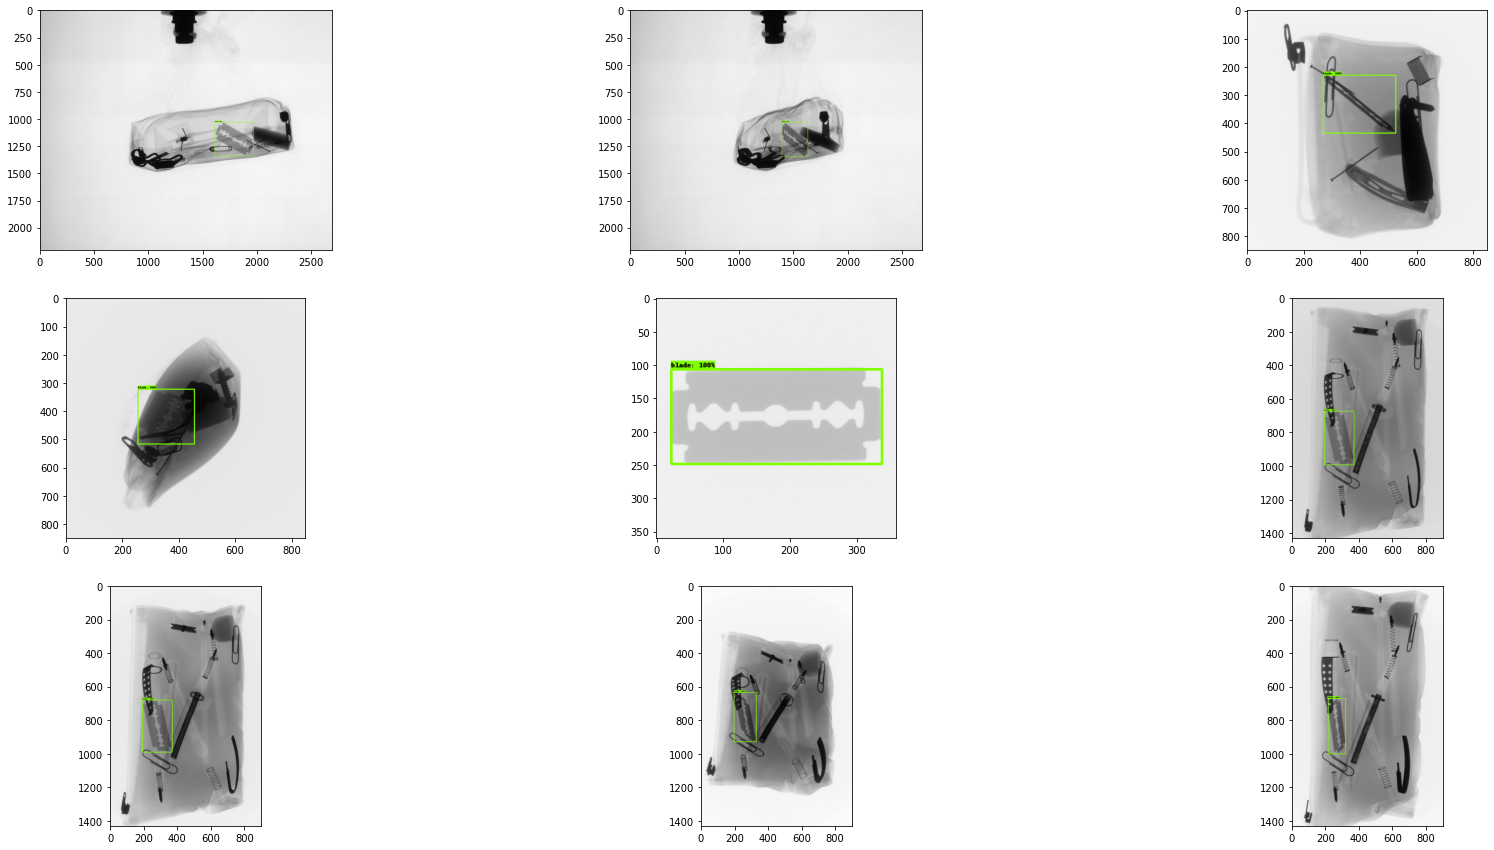

In [ ]:
dummy_scores = np.array([1.0], dtype=np.float32)  # give boxes a score of 100%

plt.figure(figsize=(30, 15))
for idx in range(9):
  plt.subplot(3, 3, idx+1)
  plot_detections(
      train_images_np[idx],
      gt_boxes[idx],
      np.ones(shape=[gt_boxes[idx].shape[0]], dtype=np.int32),
      dummy_scores, category_index)
plt.show()

# Create model and restore weights for all but last layer

In this cell we build a single stage detection architecture (RetinaNet) and restore all but the classification layer at the top (which will be automatically randomly initialized).

For simplicity, we have hardcoded a number of things in this colab for the specific RetinaNet architecture at hand (including assuming that the image size will always be 640x640), however it is not difficult to generalize to other model configurations.

In [ ]:
# Download the checkpoint and put it into models/research/object_detection/test_data/

!wget http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz
!tar -xf ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz
!mv ssd_resnet50_v1_fpn_640x640_coco17_tpu-8/checkpoint models/research/object_detection/test_data/

--2021-10-18 13:48:11--  http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 209.85.147.128, 2607:f8b0:4001:c20::80
Connecting to download.tensorflow.org (download.tensorflow.org)|209.85.147.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 244817203 (233M) [application/x-tar]
Saving to: ‘ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz.2’

ssd_resnet50_v1_fpn 100%[===================>] 233.48M   215MB/s    in 1.1s    

2021-10-18 13:48:12 (215 MB/s) - ‘ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz.2’ saved [244817203/244817203]

mv: cannot move 'ssd_resnet50_v1_fpn_640x640_coco17_tpu-8/checkpoint' to 'models/research/object_detection/test_data/checkpoint': Directory not empty


In [ ]:
tf.keras.backend.clear_session()

print('Building model and restoring weights for fine-tuning...', flush=True)
num_classes = 1
pipeline_config = 'models/research/object_detection/configs/tf2/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.config'
checkpoint_path = 'models/research/object_detection/test_data/checkpoint/ckpt-0'

# Load pipeline config and build a detection model.
#
# Since we are working off of a COCO architecture which predicts 90
# class slots by default, we override the `num_classes` field here to be just
# one (for our new rubber ducky class).
configs = config_util.get_configs_from_pipeline_file(pipeline_config)
model_config = configs['model']
model_config.ssd.num_classes = num_classes
model_config.ssd.freeze_batchnorm = True
detection_model = model_builder.build(
      model_config=model_config, is_training=True)

# Set up object-based checkpoint restore --- RetinaNet has two prediction
# `heads` --- one for classification, the other for box regression.  We will
# restore the box regression head but initialize the classification head
# from scratch (we show the omission below by commenting out the line that
# we would add if we wanted to restore both heads)
fake_box_predictor = tf.compat.v2.train.Checkpoint(
    _base_tower_layers_for_heads=detection_model._box_predictor._base_tower_layers_for_heads,
    # _prediction_heads=detection_model._box_predictor._prediction_heads,
    #    (i.e., the classification head that we *will not* restore)
    _box_prediction_head=detection_model._box_predictor._box_prediction_head,
    )
fake_model = tf.compat.v2.train.Checkpoint(
          _feature_extractor=detection_model._feature_extractor,
          _box_predictor=fake_box_predictor)
ckpt = tf.compat.v2.train.Checkpoint(model=fake_model)
ckpt.restore(checkpoint_path).expect_partial()

# Run model through a dummy image so that variables are created
image, shapes = detection_model.preprocess(tf.zeros([1, 640, 640, 3]))
prediction_dict = detection_model.predict(image, shapes)
_ = detection_model.postprocess(prediction_dict, shapes)
print('Weights restored!')

Building model and restoring weights for fine-tuning...
Weights restored!


# Eager mode custom training loop



In [ ]:
tf.keras.backend.set_learning_phase(True)

# These parameters can be tuned; since our training set has 5 images
# it doesn't make sense to have a much larger batch size, though we could
# fit more examples in memory if we wanted to.
batch_size = 10
learning_rate = 0.01
num_batches = 100

# Select variables in top layers to fine-tune.
trainable_variables = detection_model.trainable_variables
to_fine_tune = []
prefixes_to_train = [
  'WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalBoxHead',
  'WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalClassHead']
for var in trainable_variables:
  if any([var.name.startswith(prefix) for prefix in prefixes_to_train]):
    to_fine_tune.append(var)

# Set up forward + backward pass for a single train step.
def get_model_train_step_function(model, optimizer, vars_to_fine_tune):
  """Get a tf.function for training step."""

  # Use tf.function for a bit of speed.
  # Comment out the tf.function decorator if you want the inside of the
  # function to run eagerly.
  @tf.function
  def train_step_fn(image_tensors,
                    groundtruth_boxes_list,
                    groundtruth_classes_list):
    """A single training iteration.

    Args:
      image_tensors: A list of [1, height, width, 3] Tensor of type tf.float32.
        Note that the height and width can vary across images, as they are
        reshaped within this function to be 640x640.
      groundtruth_boxes_list: A list of Tensors of shape [N_i, 4] with type
        tf.float32 representing groundtruth boxes for each image in the batch.
      groundtruth_classes_list: A list of Tensors of shape [N_i, num_classes]
        with type tf.float32 representing groundtruth boxes for each image in
        the batch.

    Returns:
      A scalar tensor representing the total loss for the input batch.
    """
    shapes = tf.constant(batch_size * [[640, 640, 3]], dtype=tf.int32)
    model.provide_groundtruth(
        groundtruth_boxes_list=groundtruth_boxes_list,
        groundtruth_classes_list=groundtruth_classes_list)
    with tf.GradientTape() as tape:
      preprocessed_images = tf.concat(
          [detection_model.preprocess(image_tensor)[0]
           for image_tensor in image_tensors], axis=0)
      prediction_dict = model.predict(preprocessed_images, shapes)
      losses_dict = model.loss(prediction_dict, shapes)
      total_loss = losses_dict['Loss/localization_loss'] + losses_dict['Loss/classification_loss']
      gradients = tape.gradient(total_loss, vars_to_fine_tune)
      optimizer.apply_gradients(zip(gradients, vars_to_fine_tune))
    return total_loss

  return train_step_fn

optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
train_step_fn = get_model_train_step_function(
    detection_model, optimizer, to_fine_tune)

print('Start fine-tuning!', flush=True)
for idx in range(num_batches):
  # Grab keys for a random subset of examples
  all_keys = list(range(len(train_images_np)))
  random.shuffle(all_keys)
  example_keys = all_keys[:batch_size]

  # Note that we do not do data augmentation in this demo.  If you want a
  # a fun exercise, we recommend experimenting with random horizontal flipping
  # and random cropping :)
  gt_boxes_list = [gt_box_tensors[key] for key in example_keys]
  gt_classes_list = [gt_classes_one_hot_tensors[key] for key in example_keys]
  image_tensors = [train_image_tensors[key] for key in example_keys]

  # Training step (forward pass + backwards pass)
  total_loss = train_step_fn(image_tensors, gt_boxes_list, gt_classes_list)

  if idx % 10 == 0:
    print('batch ' + str(idx) + ' of ' + str(num_batches)
    + ', loss=' +  str(total_loss.numpy()), flush=True)

print('Done fine-tuning!')

Start fine-tuning!
batch 0 of 100, loss=1.3741279
batch 10 of 100, loss=0.72634685
batch 20 of 100, loss=0.57344276
batch 30 of 100, loss=0.67430747
batch 40 of 100, loss=0.5075054
batch 50 of 100, loss=0.25698185
batch 60 of 100, loss=0.3080607
batch 70 of 100, loss=0.25947934
batch 80 of 100, loss=0.4015715
batch 90 of 100, loss=0.343754
Done fine-tuning!


# Load test images and run inference with new model!

In [ ]:
test_image_dir = '.models/research/object_detection/test_images/blade/train/detected/'
test_images_np = []
for i in range(1, 142, 10):
  image_path = os.path.join(test_image_dir, 'V' + '{:0>4d}'.format(i) + '.jpg')
  test_images_np.append(np.expand_dims(
      load_image_into_numpy_array(image_path), axis=0))

# Again, uncomment this decorator if you want to run inference eagerly
@tf.function
def detect(input_tensor):
  """Run detection on an input image.

  Args:
    input_tensor: A [1, height, width, 3] Tensor of type tf.float32.
      Note that height and width can be anything since the image will be
      immediately resized according to the needs of the model within this
      function.

  Returns:
    A dict containing 3 Tensors (`detection_boxes`, `detection_classes`,
      and `detection_scores`).
  """
  preprocessed_image, shapes = detection_model.preprocess(input_tensor)
  prediction_dict = detection_model.predict(preprocessed_image, shapes)
  return detection_model.postprocess(prediction_dict, shapes)

# Note that the first frame will trigger tracing of the tf.function, which will
# take some time, after which inference should be fast.

label_id_offset = 1
for i in range(len(test_images_np)):
  input_tensor = tf.convert_to_tensor(test_images_np[i], dtype=tf.float32)
  detections = detect(input_tensor)

  plot_detections(
      test_images_np[i][0],
      detections['detection_boxes'][0].numpy(),
      detections['detection_classes'][0].numpy().astype(np.uint32)
      + label_id_offset,
      detections['detection_scores'][0].numpy(),
      category_index, figsize=(15, 20), image_name="gif_frame_" + ('%02d' % i) + ".jpg")

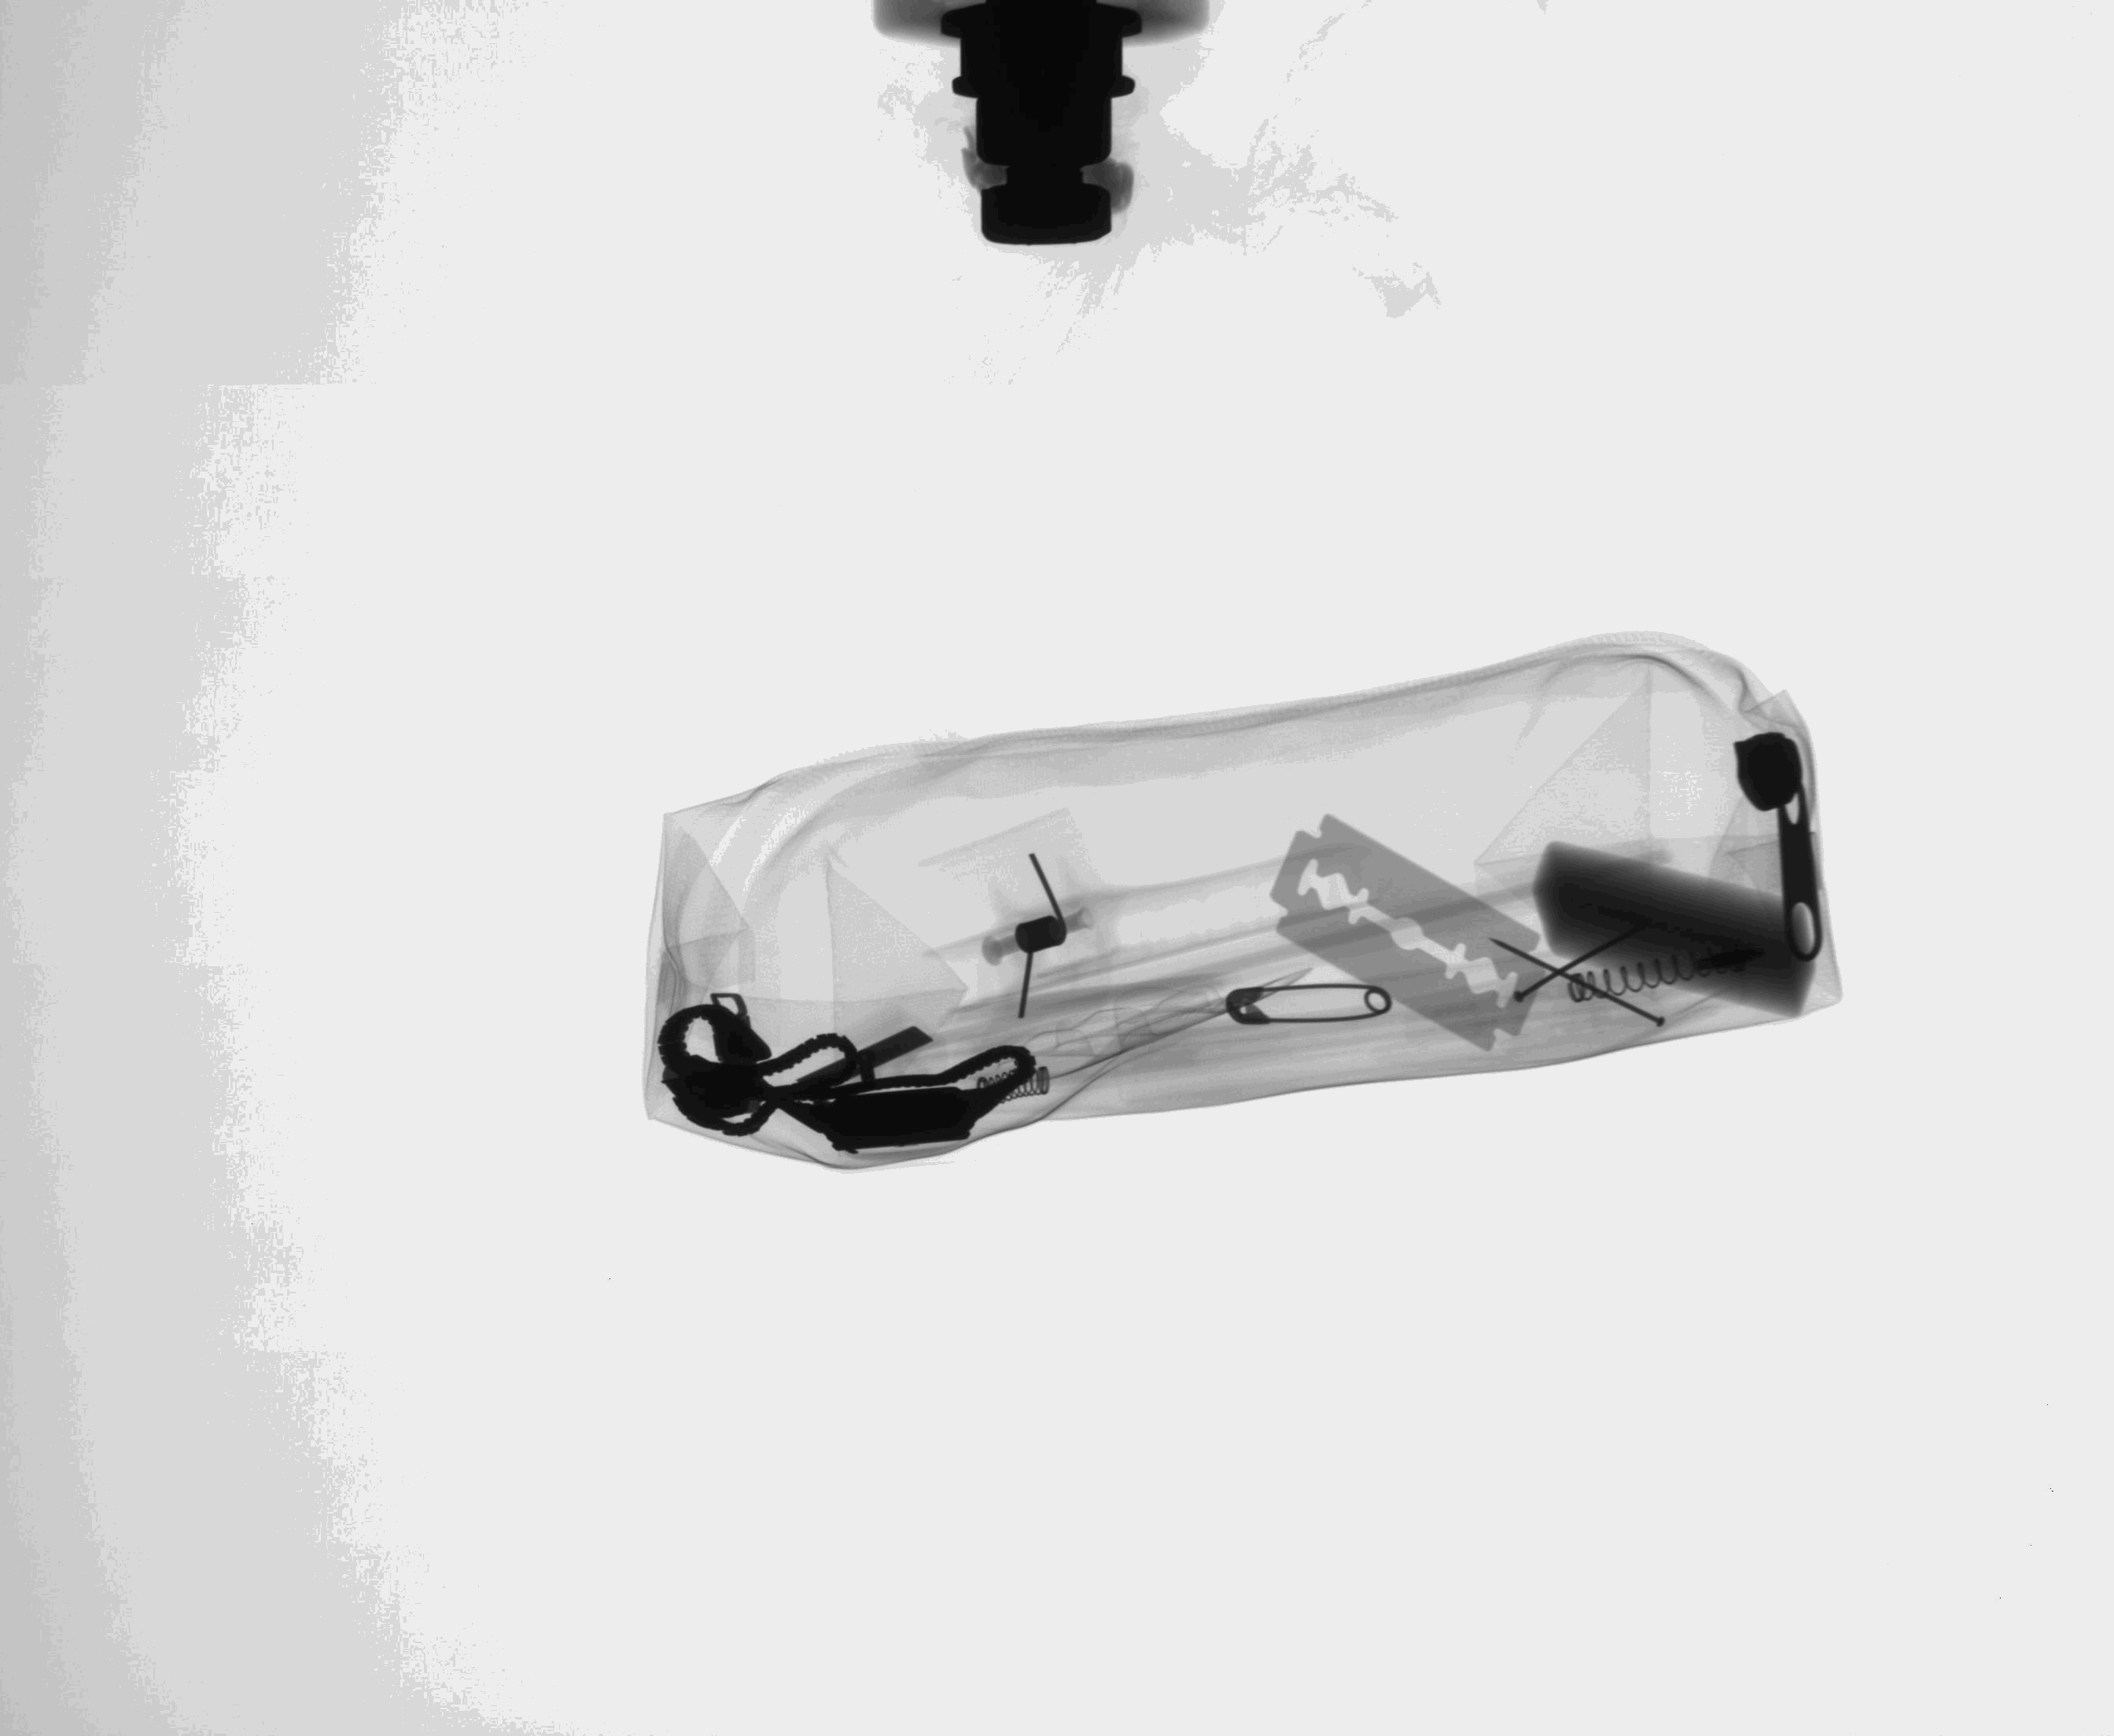

In [ ]:
imageio.plugins.freeimage.download()

anim_file = 'duckies_test.gif'

filenames = glob.glob('gif_frame_*.jpg')
filenames = sorted(filenames)
last = -1
images = []
for filename in filenames:
  image = imageio.imread(filename)
  images.append(image)

imageio.mimsave(anim_file, images, 'GIF-FI', fps=5)

display(IPyImage(open(anim_file, 'rb').read()))